# INTELLIENT GARBAGE MANAGEMENT SYSTEM FOR SMART CITIES
## CNN Based Model Development 

### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Checking if database is properly connected.

In [ ]:
img = image.load_img("/content/gdrive/My Drive/EPIC Project - Links and Papers/Dataset & Architecute Used in All papers/Garbage Dataset Collection/Dataset_Merged/Train/Garbage/[duckduckgo.com][44610].jpg")

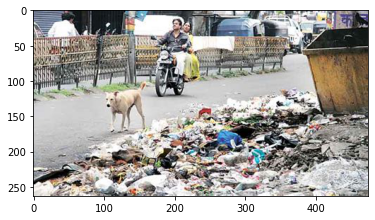

In [ ]:
plt.imshow(img)

In [ ]:
cv2.imread("/content/gdrive/My Drive/EPIC Project - Links and Papers/Dataset & Architecute Used in All papers/Garbage Dataset Collection/Dataset_Merged/Train/Garbage/[duckduckgo.com][44610].jpg").shape

(263, 474, 3)

In [ ]:
train_data_path = "/content/gdrive/My Drive/EPIC Project - Links and Papers/Dataset & Architecute Used in All papers/Garbage Dataset Collection/Dataset_Merged/Train/"
validation_data_path = "/content/gdrive/My Drive/EPIC Project - Links and Papers/Dataset & Architecute Used in All papers/Garbage Dataset Collection/Dataset_Merged/Val/"

In [ ]:
# getting data
base_dir = '/content/gdrive/My Drive/EPIC Project - Links and Papers/Dataset & Architecute Used in All papers/Garbage Dataset Collection/Dataset_Merged/'
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Val')

train_Garbage = os.path.join(train_dir, 'Garbage')
train_NonGarbage = os.path.join(train_dir, 'NonGarbage')
validation_Garbage = os.path.join(validation_dir, 'Garbage')
validation_NonGarbage = os.path.join(validation_dir, 'NonGarbage')

num_garbage_tr = len(os.listdir(train_Garbage))
num_nongarbage_tr = len(os.listdir(train_NonGarbage))
num_garbage_val = len(os.listdir(validation_Garbage))
num_nongarbage_val = len(os.listdir(validation_NonGarbage))

total_train = num_garbage_tr + num_nongarbage_tr
total_val = num_garbage_val + num_nongarbage_val

In [ ]:
BATCH_SIZE = 30
IMG_SHAPE = 128 #match image dimension to mobile net input

In [ ]:
# It generate more images using below parameters
#CNN doesn't take care of rotation, scaling etc..
#The objective of ImageDataGenerator is to import data with labels easily into the model. It is a very useful class as it has many function to rescale, rotate, zoom, flip etc. 
#ImageDataGenerator will automatically label all the data inside folders
#>ImageDataGenerator will automatically label all the data inside folders
training_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')


In [ ]:

# this is the augmentation configuration we will use for validation:
# only rescaling
valid_datagen = ImageDataGenerator(rescale=1./255)
 

In [ ]:
# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
training_data = training_datagen.flow_from_directory(train_data_path, # this is the target directory
                                      batch_size=BATCH_SIZE,
                                      target_size=(IMG_SHAPE, IMG_SHAPE),
                                      shuffle=True,
                                      class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels
 

 

Found 2154 images belonging to 2 classes.


In [ ]:
training_data.class_indices

{'Garbage': 0, 'NonGarbage': 1}

In [ ]:
#this is a similar generator, for validation data
valid_data = valid_datagen.flow_from_directory(validation_data_path,
                                  batch_size=BATCH_SIZE,
                                  target_size=(IMG_SHAPE, IMG_SHAPE),
                                  shuffle=False,
                                  class_mode='binary')

Found 924 images belonging to 2 classes.


## CNN 

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [ ]:
# model

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)), # RGB
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.5), # 1/2 of neurons will be turned off randomly
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    
    tf.keras.layers.Dense(2, activation='softmax') #[0, 1] or [1, 0]
    
    ])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


In [ ]:
EPOCHS = 50
# .fit_generator() function first accepts a batch of the dataset, then performs backpropagation on it, and then updates the weights in our model.
history = model.fit_generator(
    training_data,
    steps_per_epoch=(total_train)//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_data,
    validation_steps=(total_val)//BATCH_SIZE
    )



### Analysis of CNN Model

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8)) # pLotting accuracies 
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) # Plotting losses
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## VGG16

In [ ]:
training_data_vgg = training_datagen.flow_from_directory(train_data_path, # this is the target directory
                                      batch_size=BATCH_SIZE,
                                      target_size=(224, 224),
                                      shuffle=True,
                                      class_mode='binary')

Found 2154 images belonging to 2 classes.


In [ ]:
#this is a similar generator, for validation data
valid_data_vgg = valid_datagen.flow_from_directory(validation_data_path,
                                  batch_size=BATCH_SIZE,
                                  target_size=(224, 224),
                                  shuffle=False,
                                  class_mode='binary')

Found 924 images belonging to 2 classes.


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.vgg16 import preprocess_input

In [ ]:

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  

In [ ]:
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
model.compile(optimizer='adam', #Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.
              loss='sparse_categorical_crossentropy', #When doing multi-class classification, categorical cross entropy loss is used
              metrics=['accuracy']) #A metric is a function that is used to judge the performance of your model.

In [ ]:
history_vgg16 = model.fit_generator(
  training_data_vgg,
  validation_data=valid_data_vgg,
  epochs=5,
  steps_per_epoch=(total_train)//BATCH_SIZE,
  validation_steps=(total_val)//BATCH_SIZE 
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
72/72 [==============================] - 52s 634ms/step - loss: 0.5820 - accuracy: 0.7059 - val_loss: 0.3561 - val_accuracy: 0.8561
Epoch 2/5
72/72 [==============================] - 41s 570ms/step - loss: 0.3532 - accuracy: 0.8613 - val_loss: 0.2306 - val_accuracy: 0.9113
Epoch 3/5
72/72 [==============================] - 41s 562ms/step - loss: 0.3786 - accuracy: 0.8479 - val_loss: 0.2411 - val_accuracy: 0.9037
Epoch 4/5
72/72 [==============================] - 41s 567ms/step - loss: 0.2835 - accuracy: 0.8857 - val_loss: 0.2774 - val_accuracy: 0.8961
Epoch 5/5
72/72 [==============================] - 40s 562ms/step - loss: 0.2931 - accuracy: 0.8779 - val_loss: 0.2597 - val_accuracy: 0.9015


### Analysis of VGG16 

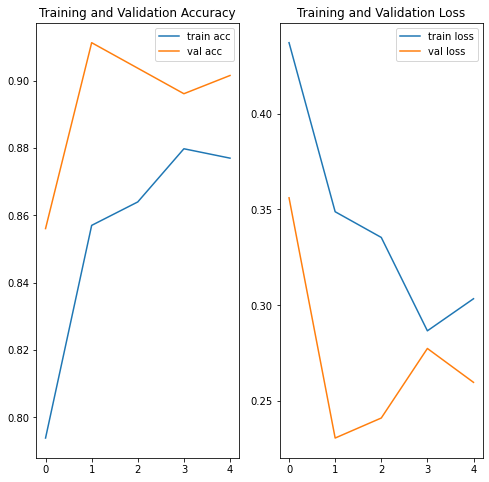

In [ ]:
# analysis of VGG16

# accuracies
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='train acc')
plt.plot(history_vgg16.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Training and Validation Accuracy')


#Losses

plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'], label='train loss')
plt.plot(history_vgg16.history['val_loss'], label='val loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('LossVal_loss')
plt.show()

## MobileNet

In [ ]:
# getting MobileNet
#URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
URL = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_128/feature_vector/4" #Feature vectors of images with MobileNet V1 (depth multiplier 1.00) trained on ImageNet.
mobile_net = hub.KerasLayer(URL, input_shape=(IMG_SHAPE, IMG_SHAPE, 3))

mobile_net.trainable = False  #Making sure that inner layers weights are not going to be trained since they are already trained on imagenet.

model = tf.keras.models.Sequential([
    mobile_net,
    tf.keras.layers.Dense(2, activation='softmax') #adding dense layer in the last for out binary classification of garbage and non garbage images.
    ])

In [ ]:
#MobileNet_v1
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1024)              3228864   
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 2,050
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
EPOCHS = 6

history = model.fit_generator(
    training_data,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=valid_data,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/6
72/72 [==============================] - 26s 345ms/step - loss: 0.5837 - accuracy: 0.7272 - val_loss: 0.2117 - val_accuracy: 0.9134
Epoch 2/6
72/72 [==============================] - 25s 342ms/step - loss: 0.2643 - accuracy: 0.8896 - val_loss: 0.1681 - val_accuracy: 0.9307
Epoch 3/6
72/72 [==============================] - 24s 339ms/step - loss: 0.2589 - accuracy: 0.8901 - val_loss: 0.1497 - val_accuracy: 0.9405
Epoch 4/6
72/72 [==============================] - 24s 338ms/step - loss: 0.2118 - accuracy: 0.9112 - val_loss: 0.1411 - val_accuracy: 0.9394
Epoch 5/6
72/72 [==============================] - 24s 336ms/step - loss: 0.2086 - accuracy: 0.9196 - val_loss: 0.1508 - val_accuracy: 0.9405
Epoch 6/6
72/72 [==============================] - 24s 337ms/step - loss: 0.1773 - accuracy: 0.9268 - val_loss: 0.1463 - val_accuracy: 0.9394


### Analysis of MobileNet

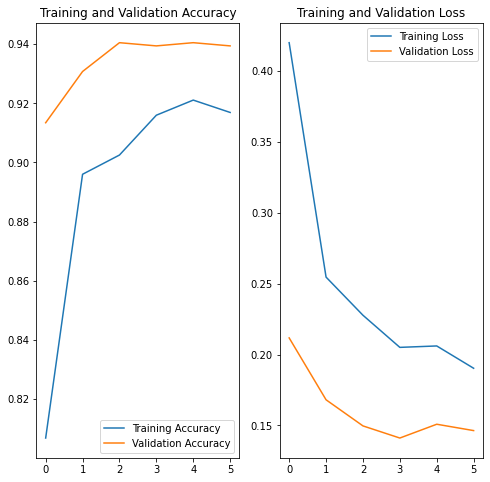

In [ ]:


# analysis of MobileNet_v1
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Checking if model is able to predict on the new test images which are not from training as well as validation data.

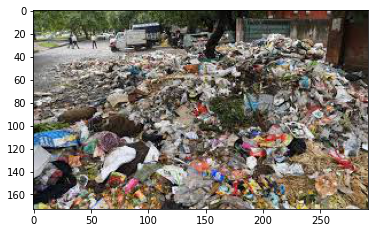

In [ ]:
#Image loaded is:
loaded_image = load_img('/content/gdrive/My Drive/EPIC Project - Links and Papers/Dataset & Architecute Used in All papers/Garbage Dataset Collection/Dataset_Merged/Test/download.jpg')
plt.imshow(loaded_image)

In [ ]:
test_image = load_img('/content/gdrive/My Drive/EPIC Project - Links and Papers/Dataset & Architecute Used in All papers/Garbage Dataset Collection/Dataset_Merged/Test/Clean_road.jpg' ,target_size=(128,128))
test_image = img_to_array(test_image)/255 # convert image to np array and scaling it
test_image = np.expand_dims(test_image, axis = 0) # change dimention 3D to 4D, Expand the shape of an array.

In [ ]:
result = model.predict(test_image).round(3) # predict garbage or not garbage in a float value.

Image does not contain Garbage


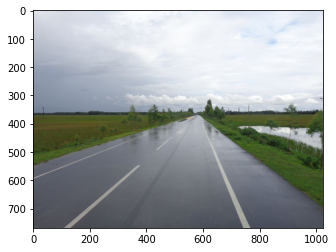

In [ ]:
pred = np.argmax(result) # get the index of max value, finding the class with the largest predicted probability.
if pred == 0:
  print("Image contains Garbage")
elif pred == 1:
  print("Image does not contain Garbage")

loaded_image = load_img('/content/gdrive/My Drive/EPIC Project - Links and Papers/Dataset & Architecute Used in All papers/Garbage Dataset Collection/Dataset_Merged/Test/Clean_road.jpg')
plt.imshow(loaded_image)

In [ ]:
model.save('models/EPICSTrial3.h5') #saving the model.

## Conversion of MobileNet .h5 model to tflite.

In [ ]:
pwd

'/content'

In [ ]:
ls

gdrive/  models/  sample_data/


In [ ]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [ ]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [ ]:
convert_bytes(get_file_size('EPICSTrial3.h5'), "MB")

File size: 12.457 Megabytes


In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp_vzfe1e3/assets


INFO:tensorflow:Assets written to: /tmp/tmp_vzfe1e3/assets


In [ ]:
#checking size of the of converted model.
tflite_model_name = "tf_lite_model.tflite"
open(tflite_model_name, "wb").write(tflite_quant_model)

3510832

In [ ]:
convert_bytes(get_file_size(tflite_model_name), "KB")

File size: 3428.547 Kilobytes
